#### Setting up features

In this notebook, we are going to analyze the features that we want to put into the model. The flow goes as this: 
* Calculate the features and add them to the data 
* Set up the regression problem 
* Do various feature selection techniques
    * Feature Importance from Random Forest 
    * Mutual Information for Classification 
    * Boruta algorithm for figuring out all the relevant features

In [52]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import yfinance as yf 
import pandas_ta as ta 

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression, f_regression

from boruta import BorutaPy

%matplotlib inline 

In [2]:
# ticker = '^GSPC'
# data = yf.download(tickers=ticker, progress=False)
# data.to_csv("data.csv")

In [27]:
data = pd.read_csv("data.csv", index_col=0)

In [28]:
start_date = '1970-01-01'
data = data.loc[start_date:]

#### Feature list

From the machine learning for trading book, there are a bunch of technical features that I want to try out. 
* Bollinger Bands Features 
* RSI features
* MACD features 
* ADX 
* Price Momentum
* Normalized Average True Range
* Aroon 
* Stochastic Relative Strength Index 
* Williams %R
* Chaikin Accumulation and Distribution
* Correlation Trend Indicator


In [29]:
willr = data.ta.willr()
rsi = data.ta.rsi() 
natr = data.ta.natr()
stoch_rsi = data.ta.stochrsi()
chaikin_money_flow = data.ta.cmf()

macd = data.ta.macd()
bbands = data.ta.bbands(length = 20, std = 2)
cti = data.ta.cti(length = 20)

# Creating the momentum factors which are the previous returns
return_periods = [1, 3, 5]
previous_returns = pd.DataFrame()
for period in return_periods: 
    col_name = f'return_{period}'
    ret = data['Close'].pct_change(period)
    previous_returns[col_name] = ret



We have all of these technical indicators, we can do some work on turning into informative stuff for us. 

#### Normalizing the MACD 

The MACD is the difference between the 12 period EMA and the 26 period EMA. We also get the *signal* line which is the 9 period EMA of the MACD line. The *histogram* is the difference between the indicator (MACD) and the signal line. There are a couple of ways that we can normalize this: 
* Divide the MACD value by the current close price
* Divide the signal line by the close price 
* Divide the absolute value of the histogram value by the close price and then apply the sign to it. 

In [30]:
macd_normalized = macd.iloc[:, 0].div(data['Close'])
macd_normalized.name = 'MACD_normalized'

macd_signal_normalized = macd.iloc[:, 1].div(data['Close'])
macd_signal_normalized.name = 'MACD_signal_normalized'

macd_histogram_normalized = macd.iloc[:, 2].div(data['Close'])
macd_histogram_normalized.name = 'MACD_histogram_normalized'

#### Normalizing the Bollinger Bands

The Bollinger bands that we get are in terms of the actual price. We want to normalize this in some way that makes sense. The bollinger band feature tells you how far you are from the different channels that they create based on standard deviation. 
* Distance in channel which is the close price - low band / (high band - low band)
    * pandas ta calculates this for us already

In [31]:
bollinger_band_feature = bbands.iloc[:, 4]

In [32]:
features = pd.concat([
    willr, rsi, natr, stoch_rsi, chaikin_money_flow, cti, previous_returns, 
    macd_normalized, macd_signal_normalized, macd_histogram_normalized, bollinger_band_feature
], axis = 1)

#### Creating the target for regression

For illustrative purposes, we are going to look at one day ahead returns as our target variable. We are going to use the close to close return for now. 



In [33]:
target = data['Close'].pct_change().shift(-1).dropna()

In [34]:
all_data = pd.concat([features, target], axis = 1).dropna()

#### Feature selection

Feature selection is the process of picking out the most relevant features for your problem so that you avoid making an overly complex model. We are going to test out a couple different methods for this: 
* Simple random forest feature importances
    * This trains a random forest model and shows the relative gain achieved by the features over the dataset
    * We are assuming that these are all relevant to our problem
* Mutual Information Regression 
    * We calculate the mutual information on all of the features to the target variable. We see which ones show up in the top K of observations 
* Boruta algorithm 
    * This is an algorithm for picking out the features that are *ALL RELEVANT* to the machine learning task at hand. 
    * This uses the random forest algorithm feature importances but does a randomization of the features such that it chooses those are actually relevant to the problem 
    * Does not tell you how they come together to solve a problem but would be helpful for taking out a lot of features in your problem 

My goal is to take out the best 5 features from these algorithms and use that for a final model. 

In [35]:
X = all_data.iloc[:, :-1]
y = all_data.iloc[:, -1]

# Doing some training and testing split. Super simple right now
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

#### Random Forest Feature importances

In here, we are going to see the feature importances from the Random Forest Model on the target variable

In [42]:
forest_model = RandomForestRegressor(
    n_estimators=500, 
    random_state=100, 
    n_jobs=-1, 
    max_depth=5
)

forest_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, n_estimators=500, n_jobs=-1,
                      random_state=100)

In [43]:
importances_forest_model = pd.Series(forest_model.feature_importances_, index = X.columns)
importances_forest_model.sort_values(ascending=True, inplace=True)

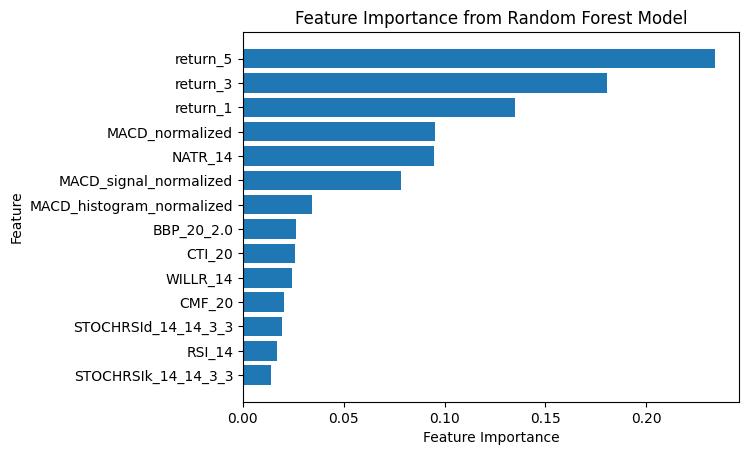

In [44]:
fig, ax = plt.subplots()
ax.barh(y = importances_forest_model.index, width = importances_forest_model)
ax.set(title = 'Feature Importance from Random Forest Model', xlabel = 'Feature Importance', ylabel = 'Feature')
plt.show()

From this initial pass, we used a Random Forest Regressor with 500 trees and max depth of 5 (to avoid overfitting). Interestingly, we see that the previous return features are the most used here. There is a large drop off in terms of importance though for the technical features of which the normalized MACD and the NATR over a 14 day period came in just at 10%. 

We can consider a model which uses the top 5 here. 

#### Mutual Information for Regression

After doing a simple feature importances from a random forest model, we are going to a mutual information regression. 

In [49]:
mutual_info_values = mutual_info_regression(X = X_train, y = y_train)
mutual_info = pd.Series(mutual_info_values, index = X_train.columns)
mutual_info.sort_values(ascending=True, inplace=True)

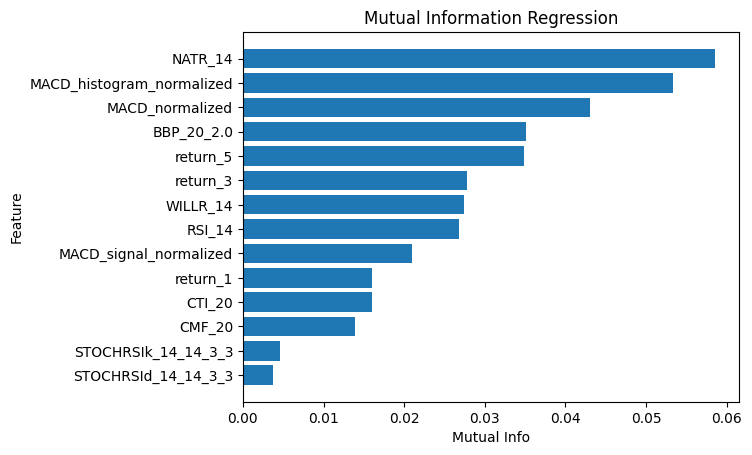

In [51]:
fig, ax = plt.subplots()
ax.barh(y = mutual_info.index, width = mutual_info)
ax.set(title = 'Mutual Information Regression', xlabel = 'Mutual Info', ylabel = 'Feature')
plt.show()

When we look at this, we see some interesting things: 
* The Normalized Average True Range comes up again as an "important feature" with the highest mutual information value 
* The mutual information for the return features are not that high but are not in the lowest categories either
* The MACD features seem to be doing well in terms of mutual information which means that they should be informative for our model

#### Boruta algorithm for All Relevant Problem

Sometimes, we want to know if the features that we have are relevant objectively. There is an algorithm that we can use for getting a determination of this. It's called the Boruta algorithm. 

At a high level, Boruta goes through each of your features and trains a random forest on them with the target. If the features are informative over some random disturbance to them, then you should keep it. 

In [53]:
boruta_forest = RandomForestRegressor(
    n_estimators = 500, 
    n_jobs = -1, 
    max_depth = 5
)

feat_selector = BorutaPy(
    estimator=boruta_forest, 
    n_estimators='auto', 
    max_iter = 100, 
    random_state=100, 
    verbose=2
)

In [58]:
feat_selector.fit(X_train.values, y_train.values)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	7
Iteration: 	9 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	7
Iteration: 	10 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	7
Iteration: 	11 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	7
Iteration: 	12 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	7
Iteration: 	13 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	7
Iteration: 	14 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	7
Iteration: 	15 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	7
Iteration: 	16 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	7
Iteration:

BorutaPy(estimator=RandomForestRegressor(max_depth=5, n_estimators=74,
                                         n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x7F91E8425640),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7F91E8425640, verbose=2)

We can extract the features that were chosen and rejected from our feature selector object. 

In [65]:
X.loc[:, feat_selector.support_].head(2)

,NATR_14,return_1,return_3,return_5,MACD_normalized,MACD_signal_normalized
Date,,,,,,
1970-02-18,2.010058,0.012389,0.010400,0.005751,-0.016450,0.006210
1970-02-19,2.002924,0.003660,0.014918,0.011876,-0.014305,0.006618


The features that were chosen from the Boruta algorithm as "relevant" were: 
* NATR 14 -> Normalized Average True Range 
* Return on 1, 3, and 5 day time frame 
* MACD level normalized
* MACD signal normalized

### Conclusions 

In this notebook, we started putting the data together and thinking about how we could go ahead and choose the features which go into our model. 
* In the feature importances on a random regression tree, we saw that the returns gave a very high level of importance 
    * This makes sense given that we know returns tend to have some sort of autocorrelation to them 
* In the mutual information regression, we did not get too much confirmation on what we saw in the feature importance part
* We utilized the boruta algorithm to come up with the "all relevant" features out the of the features that we provided into the model. 
    * Out of this, we got three technical features that we should test out (NATR_14, MACD normalized and MACD signal normalized)


I think that for our model going forward, we will say that we will use the features left over from the Boruta algorithm for now. 